# Validation: The Egg model (oil-water compressible)
A two-phase model that is taken from the first member of the EGG ensemble. The
model is a synthetic case with channelized permeability and water injection
with fixed controls. For more details, see the paper where the ensemble is
introduced:

[Jansen, Jan-Dirk, et al. "The egg model–a geological ensemble for reservoir
simulation." Geoscience Data Journal 1.2 (2014): 192-195.](https://doi.org/10.1002/gdj3.21)

In [1]:
using Jutul, JutulDarcy, GLMakie, DelimitedFiles, HYPRE
egg_dir = JutulDarcy.GeoEnergyIO.test_input_file_path("EGG")
case = setup_case_from_data_file(joinpath(egg_dir, "EGG.DATA"))
ws, states = simulate_reservoir(case, output_substates = true)

     Failure artifact: EGG
Simulating 9 years, 44.69 weeks as 135 report steps   1%  ETA: 0:06:09
  Progress:  Solving step 2/135 (0.14% of time interval complete)


Simulating 9 years, 44.69 weeks as 135 report steps   2%  ETA: 0:04:30
  Progress:  Solving step 3/135 (0.28% of time interval complete)


Simulating 9 years, 44.69 weeks as 135 report steps   3%  ETA: 0:03:36
  Progress:  Solving step 4/135 (0.56% of time interval complete)


Simulating 9 years, 44.69 weeks as 135 report steps   4%  ETA: 0:03:04
  Progress:  Solving step 5/135 (0.83% of time interval complete)


Simulating 9 years, 44.69 weeks as 135 report steps   4%  ETA: 0:02:42
  Progress:  Solving step 6/135 (1.11% of time interval complete)


Simulating 9 years, 44.69 weeks as 135 report steps   5%  ETA: 0:02:27
  Progress:  Solving step 7/135 (1.39% of time interval complete)


Simulating 9 years, 44.69 weeks as 135 report steps   6%  ETA: 0:02:16
  Progress:  Solving step 8/135 (1.67% of time interval complete)




ReservoirSimResult with 162 entries:

  wells (12 present):
    :PROD4
    :INJECT5
    :INJECT4
    :INJECT8
    :INJECT6
    :INJECT1
    :INJECT7
    :INJECT3
    :PROD2
    :PROD3
    :PROD1
    :INJECT2
    Results per well:
       :lrat => Vector{Float64} of size (162,)
       :wrat => Vector{Float64} of size (162,)
       :Aqueous_mass_rate => Vector{Float64} of size (162,)
       :orat => Vector{Float64} of size (162,)
       :control => Vector{Symbol} of size (162,)
       :bhp => Vector{Float64} of size (162,)
       :Liquid_mass_rate => Vector{Float64} of size (162,)
       :mass_rate => Vector{Float64} of size (162,)
       :rate => Vector{Float64} of size (162,)

  states (Vector with 162 entries, reservoir variables for each state)
    :Saturations => Matrix{Float64} of size (2, 18553)
    :Pressure => Vector{Float64} of size (18553,)
    :TotalMasses => Matrix{Float64} of size (2, 18553)

  time (report time for each state)
     Vector{Float64} of length 162

  result (e

## Plot the reservoir solution

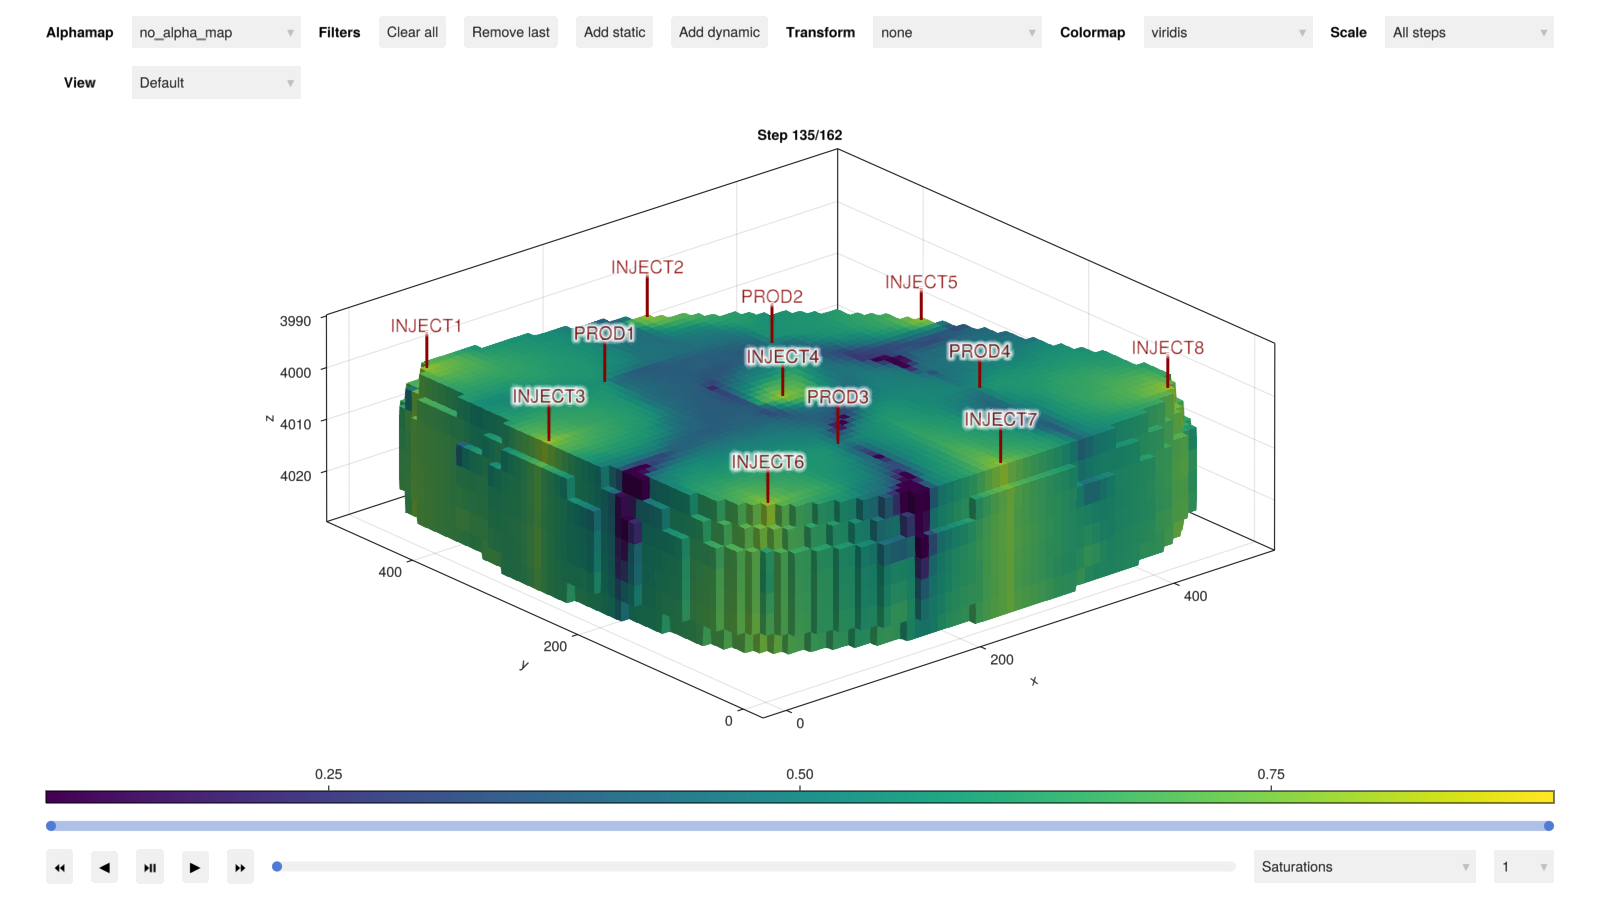

In [2]:
plot_reservoir(case.model, states, step = 135, key = :Saturations)

## Load reference solution (OPM Flow)
We load a CSV file with the reference solution and set up plotting

In [3]:
csv_path = joinpath(egg_dir, "REFERENCE.CSV")
data, header = readdlm(csv_path, ',', header = true)
time_ref = data[:, 1]
time_jutul = deepcopy(ws.time)
wells = deepcopy(ws.wells)
wnames = collect(keys(wells))
nw = length(wnames)
day = si_unit(:day)
cmap = :tableau_hue_circle

inj = Symbol[]
prod = Symbol[]
for (wellname, well) in pairs(wells)
    qts = well[:wrat] + well[:orat]
    if sum(qts) > 0
        push!(inj, wellname)
    else
        push!(prod, wellname)
    end
end

function plot_well_comparison(response, well_names, reponse_name = "$response")
    fig = Figure(size = (1000, 400))
    if response == :bhp
        ys = 1/si_unit(:bar)
        yl = "Bottom hole pressure / Bar"
    elseif response == :wrat
        ys = si_unit(:day)
        yl = "Surface water rate / m³/day"
    elseif response == :orat
        ys = si_unit(:day)/(1000*si_unit(:stb))
        yl = "Surface oil rate / 10³ stb/day"
    else
        error("$response not ready.")
    end
    welltypes = []
    ax = Axis(fig[1:4, 1], xlabel = "Time / days", ylabel = yl)
    i = 1
    linehandles = []
    linelabels = []
    for well_name in well_names
        well = wells[well_name]
        label_in_csv = "$well_name:$response"
        ref_pos = findfirst(x -> x == label_in_csv, vec(header))
        qoi = copy(well[response]).*ys
        qoi_ref = data[:, ref_pos].*ys
        tot_rate = copy(well[:rate])
        @. qoi[tot_rate == 0] = NaN
        orat_ref = data[:, findfirst(x -> x == "$well_name:orat", vec(header))]
        wrat_ref = data[:, findfirst(x -> x == "$well_name:wrat", vec(header))]
        tot_rate_ref = orat_ref + wrat_ref
        @. qoi_ref[tot_rate_ref == 0] = NaN
        crange = (1, max(length(well_names), 2))
        lh = lines!(ax, time_jutul./day, abs.(qoi),
            color = i,
            colorrange = crange,
            label = "$well_name", colormap = cmap
        )
        push!(linehandles, lh)
        push!(linelabels, "$well_name")
        lines!(ax, time_ref./day, abs.(qoi_ref),
            color = i,
            colorrange = crange,
            linestyle = :dash,
            colormap = cmap
        )
        i += 1
    end
    l1 = LineElement(color = :black, linestyle = nothing)
    l2 = LineElement(color = :black, linestyle = :dash)

    Legend(fig[1:3, 2], linehandles, linelabels, nbanks = 3)
    Legend(fig[4, 2], [l1, l2], ["JutulDarcy.jl", "E100"])
    fig
end

plot_well_comparison (generic function with 2 methods)

## Well responses and comparison
### Water production rates

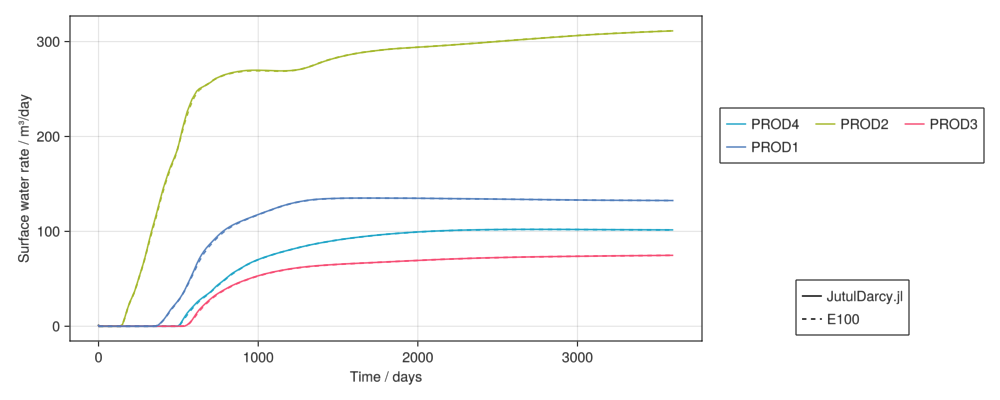

In [4]:
plot_well_comparison(:wrat, prod, "Water surface rate")

### Oil production rates

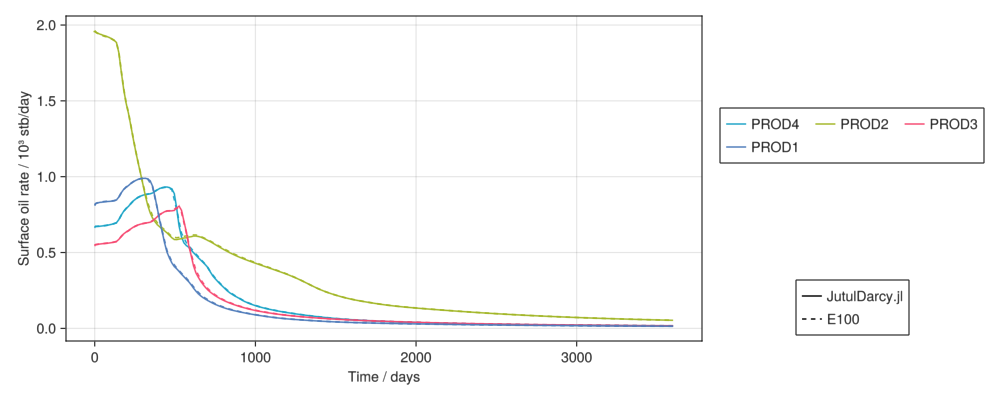

In [5]:
plot_well_comparison(:orat, prod, "Oil surface rate")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*